## Carga dos dados

In [19]:
#libs
import pandas as pd
import numpy as np

from os import listdir, chdir
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

np.random.seed(595)

In [20]:
#Carga dos dados
chdir('../input')
files = listdir()

df_train = pd.read_csv(files[0])
df_test = pd.read_csv(files[1])
assert(df_train['SalePrice'].isnull().sum() == 0)

In [21]:
df_train.shape

(1460, 81)

## Pré-processamento

In [22]:
train = df_train.copy()

In [23]:
#Colunas por tipo
cat_vars = train.select_dtypes(include='object').columns
num_vars = train.select_dtypes(include=['int','float']).columns
assert(len(cat_vars) + len(num_vars) == df_train.shape[1])

In [24]:
#Presença de valores NA
na_cat_vars = train[cat_vars].isnull().sum()
na_cat_vars = na_cat_vars[na_cat_vars > 0]

na_num_vars = train[num_vars].isnull().sum()
na_num_vars = na_num_vars[na_num_vars > 0]

In [25]:
print(na_cat_vars)
print(na_num_vars)

Alley           1369
MasVnrType         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64
LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64


### Etapas

* Substituir variáveis Garage:
        + HasGarage: Binário, 0 quando GarageFinish = NA
        + GarageFinish: Binário, 0  quando GarageFinish = NA OU 'Unf'
* Imputar constante zero nos registros NA da variável *MasVnrArea*
* Imputar mediana nos registros NA das variáveis *LotFrontage*

In [26]:
#Substituir as variáveis Garage
replace_cols_1_garage = train.filter(like='Garage')

In [27]:
#Imputar constante zero nos registros NA da variável 'MasVnrArea'
impute_cols_1_constant_zero = train[['MasVnrArea']]

In [28]:
#Variáveis a imputar median em caso de missing
impute_cols_2_median = train[['LotFrontage']]

## Transformers

In [29]:
class GarageTransform(BaseEstimator, TransformerMixin):   
    '''
    Tarefas:
    * Criar coluna HasGarage: 0 se GarageFinish == NA, 1 caso contrário
    * Criar coluna GarageStatus: 0 se GarageFinish in [NA,'Unf'], 1 caso contrário
    * Remover demais colunas
    '''
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, dataFrame):
        output = dataFrame.copy()
        cols_to_drop = output.filter(like='Garage').columns
        
        #Criar coluna HasGarage
        output['HasGarage'] = output['GarageType'].isna()
        output['HasGarage'] *= 1
        
        #Criar coluna GarageStatus
        output['GarageStatus'] = 1
        index_garagefinish_isna = output[output['GarageFinish'].isna()].index
        index_garagefinish_unf = output[output['GarageFinish'] == 'Unf'].index
        output.loc[index_garagefinish_isna, 'GarageStatus'] = 0
        output.loc[index_garagefinish_unf, 'GarageStatus'] = 0

        #Remover demais colunas
        return output.drop(columns=cols_to_drop)
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [32]:
#Train/test Split
X_train, X_test, y_train, y_test = train_test_split(df_train.drop('SalePrice', axis=1), df_train['SalePrice'], train_size=0.7)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1021, 80) (439, 80) (1021,) (439,)


/home/gustavo/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Transformers, Pipeline e Model

In [49]:
#Preprocess Transformer
ct_prep = ColumnTransformer(transformers=[('Transmute_garage', GarageTransform(), replace_cols_1_garage.columns),
                                          ('Mutate_constant', SimpleImputer(strategy='constant', fill_value=0), impute_cols_1_constant_zero.columns),
                                          ('Mutate_median', SimpleImputer(strategy='median'), impute_cols_2_median.columns)],
                           remainder='drop')

In [50]:
#Model
rf_model = RandomForestRegressor(criterion='mae')

rf_params = {'max_depth': [3,5,7,9,12],
             'min_samples_split': [2,3,4,5,6,7],
             'min_samples_leaf': [1,3,5,7,10]}

rf_random_cv = RandomizedSearchCV(rf_model,
                                   param_distributions=rf_params,
                                   cv=5,
                                   n_iter=100,
                                   scoring='neg_mean_squared_error')

In [55]:
pipe_model = Pipeline(steps=[('Prep', ct_prep),
                             ('Model', rf_model)])
pipe_model.fit(X_train, y_train)

/home/gustavo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
     steps=[('Prep', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('Mutate_constant', SimpleImputer(copy=True, fill_value=0, missing_values=nan,
       strategy='constant', verbose=0), Index(['MasVnrArea'], dtype='object'...ators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])

In [52]:
preds = pipe_model.predict(X_test)
score = mean_absolute_error(y_test, preds)
score

44660.386560364466

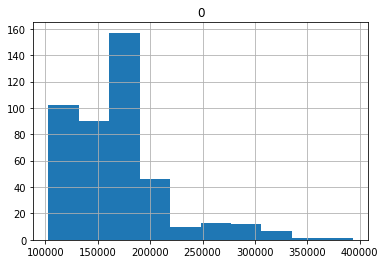

In [57]:
import matplotlib.pyplot as plt
pd.DataFrame(preds).hist()
plt.show()

Adicionar novas features piorou bastante o resultado do modelo preditivo em relação aos resultados obtidos no Kaggle.

Vou gerar um arquivo com as previsões e verificar o resultado na plataforma.

### Submission file

In [58]:
chdir('../output')
submission_preds = pipe_model.predict(df_test)
df_submit = pd.DataFrame({'Id': df_test.Id,
                          'SalePrice': submission_preds})
df_submit.to_csv('02-pipeline-model_3.csv', index=False)

Score model_1: 40219
Score model_2: 46615
Score model_3: 47754